In [ ]:
#Importing system modules
import os
import itertools
from PIL import Image

In [ ]:
#Importing preprocessing modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
#Importing Deep learning modules
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG19
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [ ]:

# Load training data
train_dir = "/content/drive/MyDrive/brain_tumor_dataset/Training"
train_data = []

for label in os.listdir(train_dir):
    label_dir = os.path.join(train_dir, label)
    for image in os.listdir(label_dir):
        image_path = os.path.join(label_dir, image)
        train_data.append({"Paths": image_path, "Labels": label})

train_df = pd.DataFrame(train_data)

In [ ]:
# Load testing data
test_dir = "/content/drive/MyDrive/brain_tumor_dataset/Testing"
test_data = []

for label in os.listdir(test_dir):
    label_dir = os.path.join(test_dir, label)
    for image in os.listdir(label_dir):
        image_path = os.path.join(label_dir, image)
        test_data.append({"Paths": image_path, "Labels": label})

test_df = pd.DataFrame(test_data)

In [ ]:
# Split test data
valid_df, test_df = train_test_split(test_df, train_size=0.5, shuffle=True, random_state=123)
print(valid_df.shape)
print(test_df.shape)

(655, 2)
(656, 2)


In [ ]:
# Define image data generators with augmentation
batch_size = 32
img_size = (224, 224)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="Paths",
    y_col="Labels",
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb'
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="Paths",
    y_col="Labels",
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb'
)

Found 5722 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


In [ ]:
print(test_df.columns)

Index(['Paths', 'Labels'], dtype='object')


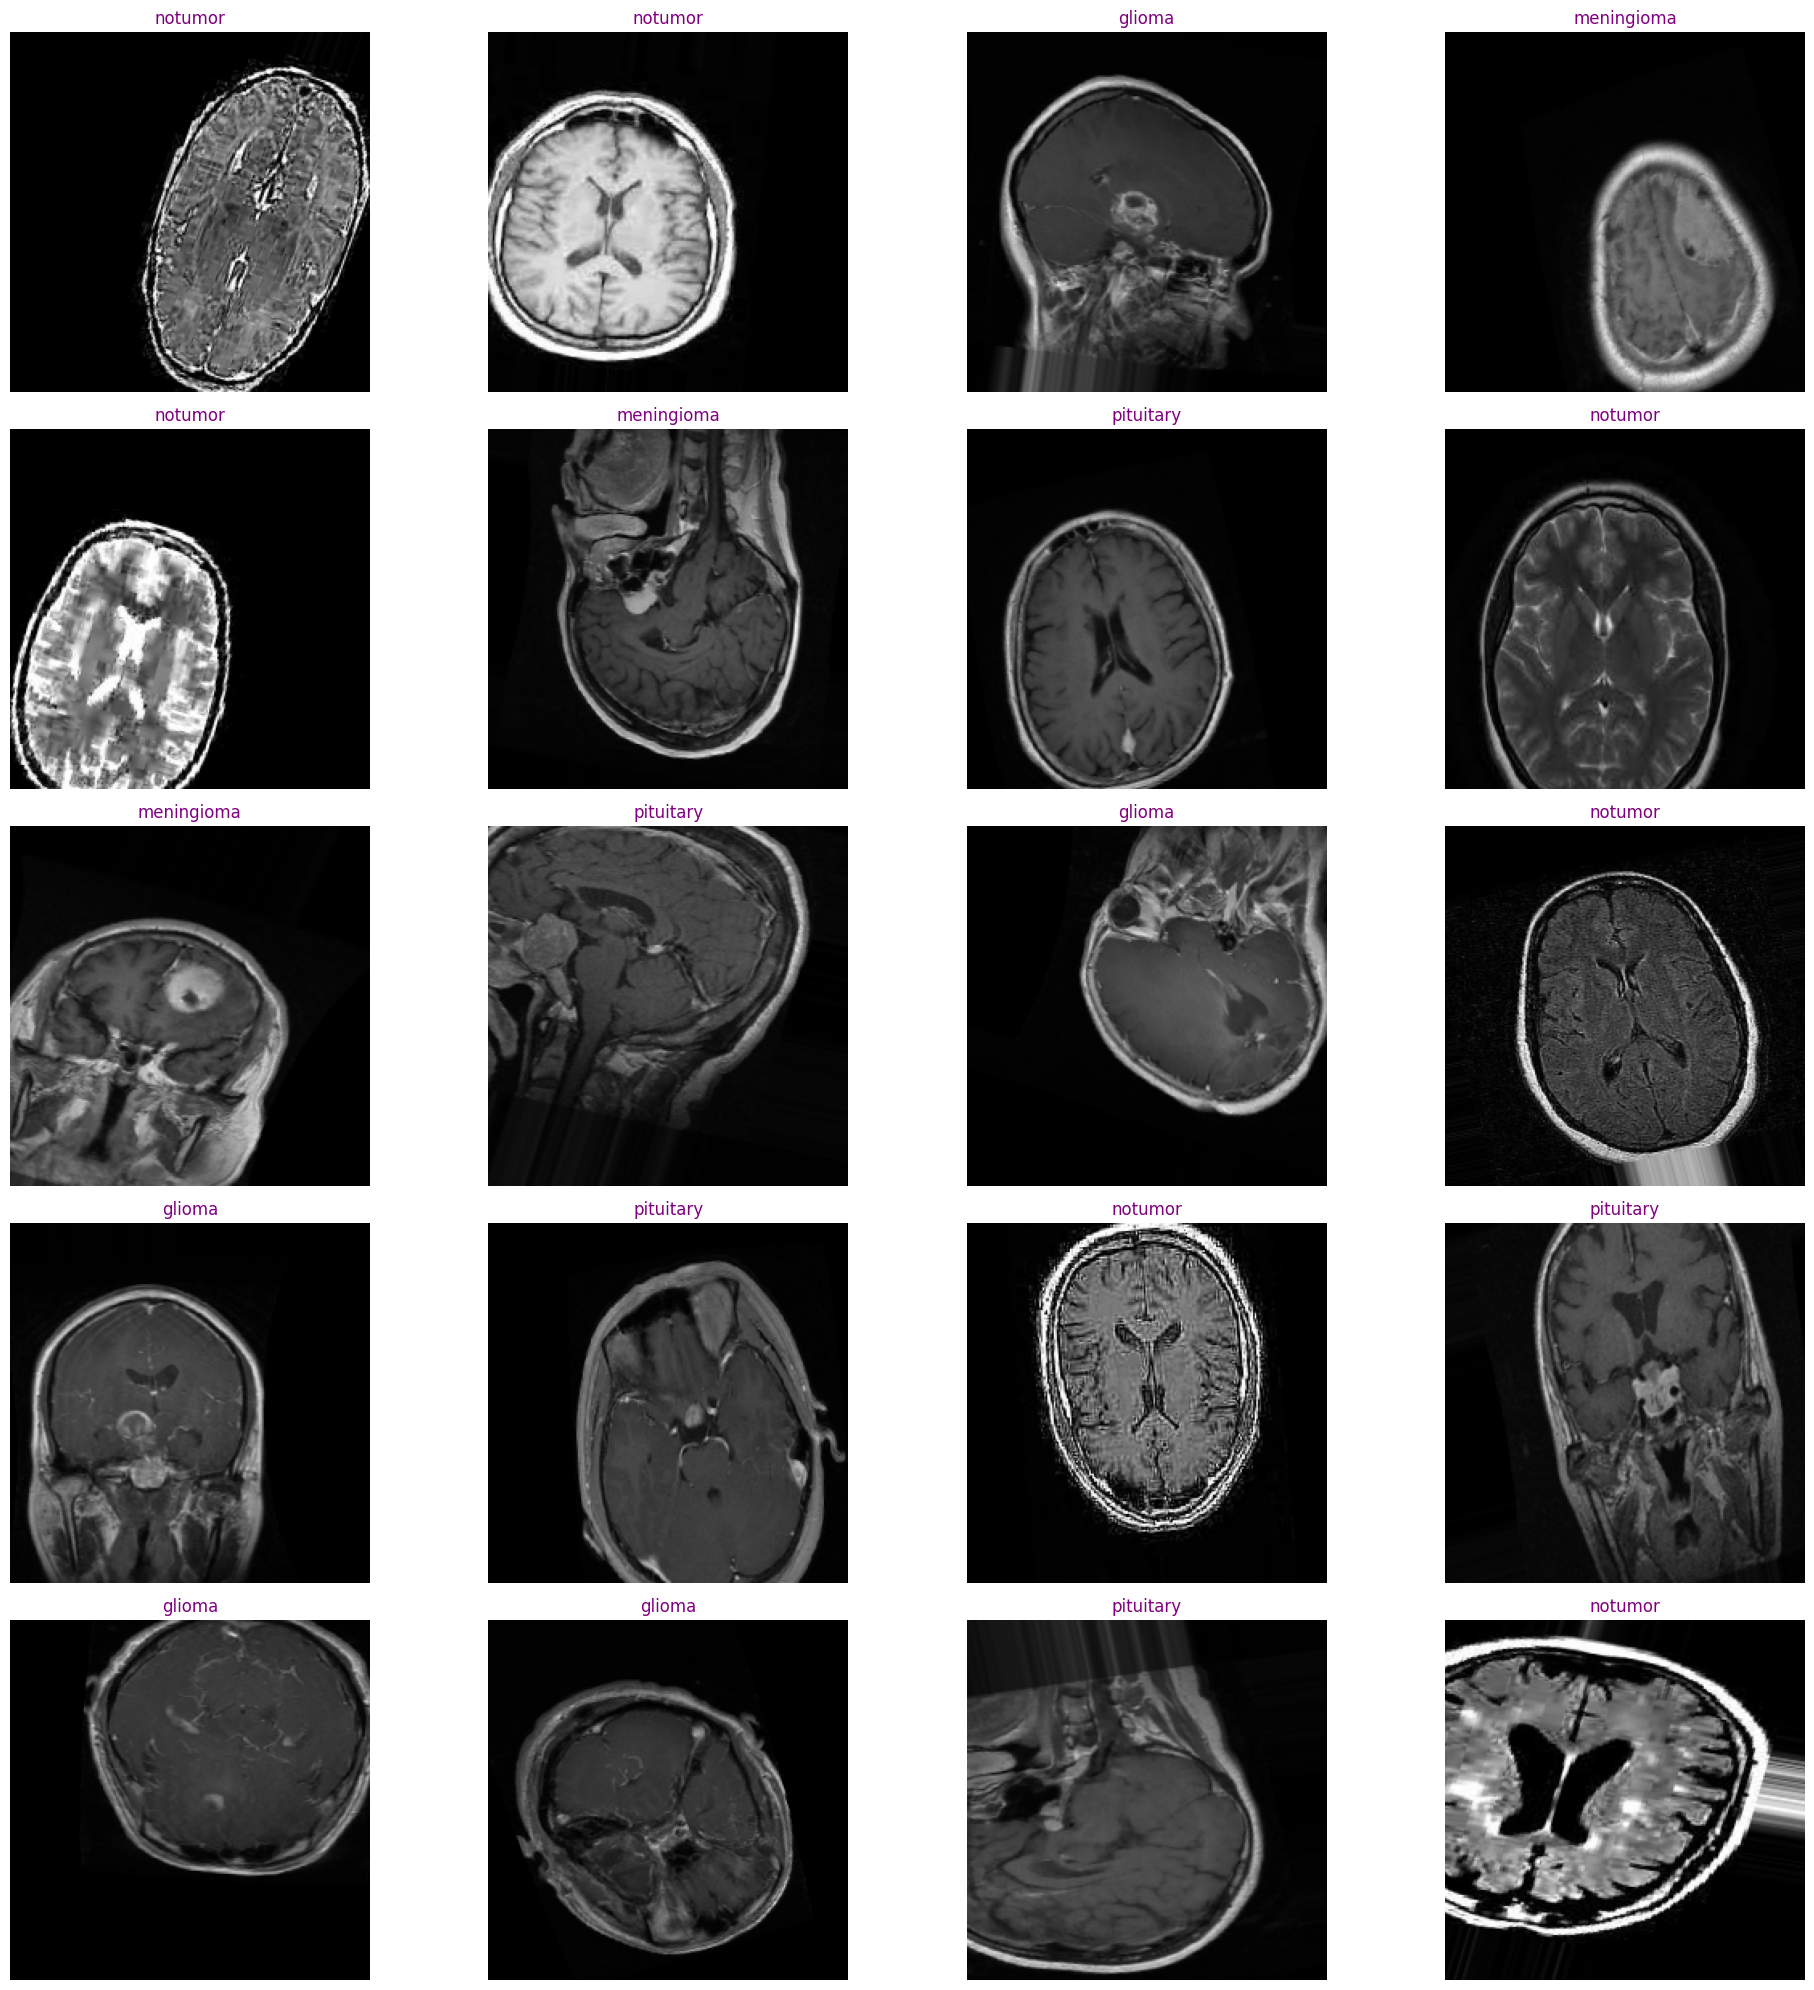

In [ ]:
# Generate a batch of images for plotting
imgs, labels = next(train_generator)

# Get class indices from the generator
class_indices = train_generator.class_indices

# Get class labels
Keys = list(class_indices.keys())

# Sample plotting
plt.figure(figsize=(20, 20))
for i in range(20):
    plt.subplot(5, 4, i + 1)
    im = imgs[i]  # Remove normalization for debugging purposes
    plt.imshow(im)

    index = np.argmax(labels[i])
    label = Keys[index]
    plt.title(label, color="purple")
    plt.axis("off")
plt.tight_layout()
plt.show()


# **VGG19**

In [ ]:
# Define VGG21 model architecture
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))

80134624/80134624 [==============================] - 0s 0us/step


In [ ]:
# Fine-tune the last few layers of the base model
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Add custom head on top of the base model
x = base_model.output
x = Conv2D(512, (3, 3), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), strides=(2, 2))(x)
x = Conv2D(512, (3, 3), padding='same', activation='relu')(x)  # Additional convolutional layer
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), strides=(2, 2))(x)  # Additional max pooling layer
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(4, activation='softmax')(x)

In [ ]:
# Create the modified VGG21 model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model with a lower initial learning rate
model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.000001)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', verbose=1, save_best_only=True)

In [ ]:
# Train the model with a higher number of epochs
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=test_generator,
    callbacks=[early_stopping, reduce_lr, checkpoint]
)

Epoch 1/50
179/179 [==============================] - ETA: 0s - loss: 1.1522 - accuracy: 0.5530
Epoch 1: val_accuracy improved from -inf to 0.68293, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


179/179 [==============================] - 331s 2s/step - loss: 1.1522 - accuracy: 0.5530 - val_loss: 0.8138 - val_accuracy: 0.6829 - lr: 1.0000e-05
Epoch 2/50
179/179 [==============================] - ETA: 0s - loss: 0.9304 - accuracy: 0.6237
Epoch 2: val_accuracy improved from 0.68293 to 0.69512, saving model to best_model.h5
179/179 [==============================] - 133s 743ms/step - loss: 0.9304 - accuracy: 0.6237 - val_loss: 0.7924 - val_accuracy: 0.6951 - lr: 1.0000e-05
Epoch 3/50
179/179 [==============================] - ETA: 0s - loss: 0.8091 - accuracy: 0.6798
Epoch 3: val_accuracy improved from 0.69512 to 0.74848, saving model to best_model.h5
179/179 [==============================] - 133s 741ms/step - loss: 0.8091 - accuracy: 0.6798 - val_loss: 0.7378 - val_accuracy: 0.7485 - lr: 1.0000e-05
Epoch 4/50
179/179 [==============================] - ETA: 0s - loss: 0.7158 - accuracy: 0.7207
Epoch 4: val_accuracy improved from 0.74848 to 0.76982, saving model to best_model.h5
1

In [ ]:
# Evaluate the model
train_score = model.evaluate(train_generator, verbose=0)
test_score = model.evaluate(test_generator, verbose=0)

print('Train Accuracy:', train_score[1])
print('Test Accuracy:', test_score[1])

Train Accuracy: 0.9480950832366943
Test Accuracy: 0.9024389982223511


In [ ]:
pred= model.predict(test_gebnera)
print(classification_report(y_test,pred))

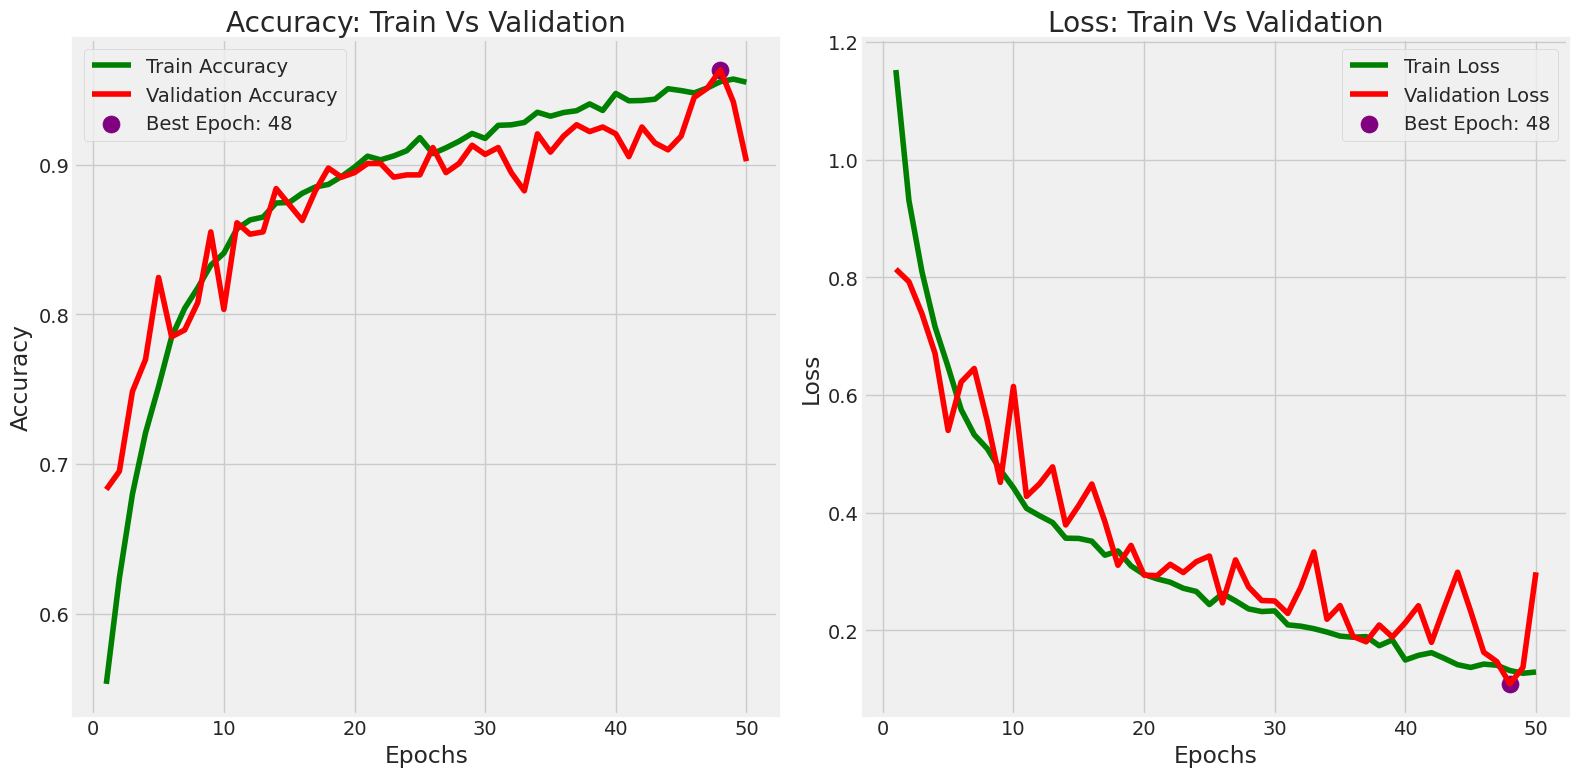

In [ ]:
# Gather information from history
Epochs = range(1, len(history.history['accuracy']) + 1)
tr_acc = history.history['accuracy']
v_acc = history.history['val_accuracy']
tr_loss = history.history['loss']
v_loss = history.history['val_loss']

# Find the epoch with the highest validation accuracy and lowest validation loss
best_epoch_acc = np.argmax(history.history['val_accuracy']) + 1
best_val_accuracy = history.history['val_accuracy'][best_epoch_acc - 1]

best_epoch_loss = np.argmin(history.history['val_loss']) + 1
best_val_loss = history.history['val_loss'][best_epoch_loss - 1]

# Plot visualization
plt.figure(figsize=(16, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_acc, "g", label="Train Accuracy")
plt.plot(Epochs, v_acc, "r", label="Validation Accuracy")
plt.scatter(best_epoch_acc, best_val_accuracy, s=150, color='purple', label=f'Best Epoch: {best_epoch_acc}')

plt.title("Accuracy: Train Vs Validation")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_loss, "g", label="Train Loss")
plt.plot(Epochs, v_loss, "r", label="Validation Loss")
plt.scatter(best_epoch_loss, best_val_loss, s=150, color='purple', label=f'Best Epoch: {best_epoch_loss}')

plt.title("Loss: Train Vs Validation")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


21/21 [==============================] - 5s 205ms/step


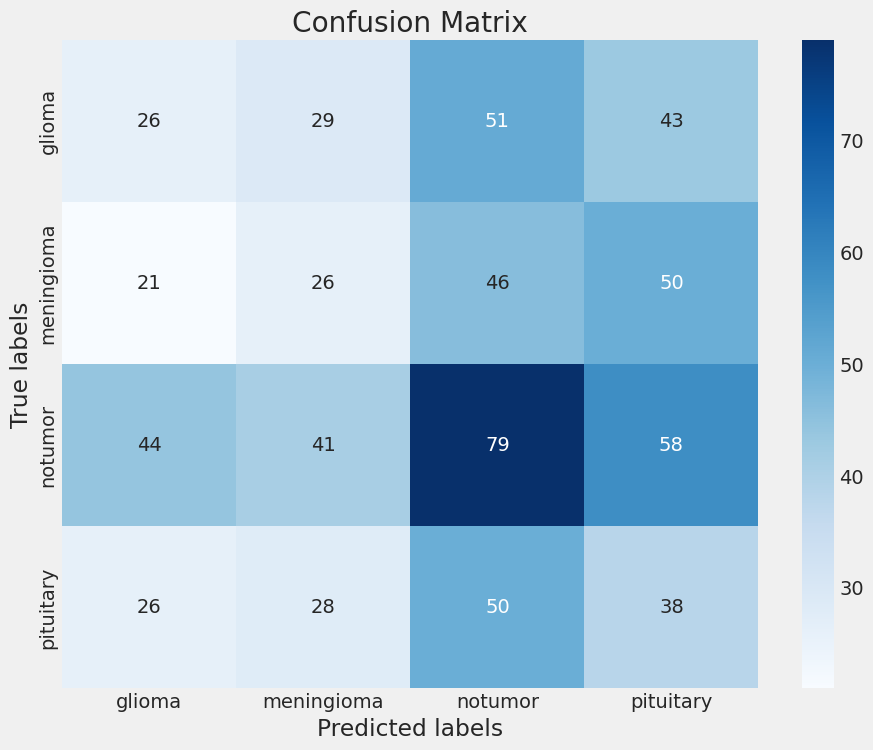

In [ ]:
# Make predictions on the test data
y_pred = model.predict(test_generator)
y_true = test_generator.classes

# Convert predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Get class labels
class_labels = list(test_generator.class_indices.keys())

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()
